In [0]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

import os
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Train
# normal
print(len(os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/train/NORMAL')))
# pneumonia
print(len(os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/train/PNEUMONIA')))

1341
3876


In [0]:
train_normal_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/train/NORMAL')
train_pneu_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/train/PNEUMONIA')
val_normal_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/val/NORMAL')
val_pneu_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/val/PNEUMONIA')
test_normal_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/test/NORMAL')
test_pneu_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/test/PNEUMONIA')

In [0]:
def assign_pneu_type(x):
    x = str(x)
    if 'virus' in x:
        return 'viral'
    if 'bacteria' in x:
        return 'bacterial'

In [0]:
# TRAIN_NORMAL
# create the dataframe
df_train_normal = pd.DataFrame(train_normal_list, columns=['image_id'])
# delete the entry named .DS_Store
df_train_normal = df_train_normal[df_train_normal['image_id'] != '.DS_Store']
# create a new target column
df_train_normal['target'] = 'normal'

# TRAIN_PNEU
# create the dataframe
df_train_pneu = pd.DataFrame(train_pneu_list, columns=['image_id'])
# delete the entry named .DS_Store
df_train_pneu = df_train_pneu[df_train_pneu['image_id'] != '.DS_Store']
# create a target column that's a copy of the image column
df_train_pneu['target'] = df_train_pneu['image_id']
# apply the function to this target column
df_train_pneu['target'] = df_train_pneu['target'].apply(assign_pneu_type)

# VAL_NORMAL
# create the dataframe
df_val_normal = pd.DataFrame(val_normal_list, columns=['image_id'])
# delete the entry named .DS_Store
df_val_normal = df_val_normal[df_val_normal['image_id'] != '.DS_Store']
# create a new target column
df_val_normal['target'] = 'normal'


# VAL_PNEU
# create the dataframe
df_val_pneu = pd.DataFrame(val_pneu_list, columns=['image_id'])
# delete the entry named .DS_Store
df_val_pneu = df_val_pneu[df_val_pneu['image_id'] != '.DS_Store']
# create a target column that's a copy of the image column
df_val_pneu['target'] = df_val_pneu['image_id']
# apply the function to this target column
df_val_pneu['target'] = df_val_pneu['target'].apply(assign_pneu_type)


# TEST_NORMAL
# create the dataframe
df_test_normal = pd.DataFrame(test_normal_list, columns=['image_id'])
# delete the entry named .DS_Store
df_test_normal = df_test_normal[df_test_normal['image_id'] != '.DS_Store']
# create a new target column
df_test_normal['target'] = 'normal'


# TEST_PNEU
# create the dataframe
df_test_pneu = pd.DataFrame(test_pneu_list, columns=['image_id'])
# delete the entry named .DS_Store
df_test_pneu = df_test_pneu[df_test_pneu['image_id'] != '.DS_Store']
# create a target column that's a copy of the image column
df_test_pneu['target'] = df_test_pneu['image_id']
# apply the function to this target column
df_test_pneu['target'] = df_test_pneu['target'].apply(assign_pneu_type)

In [0]:
# Concat the dataframes
df_data = \
pd.concat([df_train_normal,df_train_pneu,df_val_normal,df_val_pneu,df_test_normal,
           df_test_pneu],axis=0).reset_index(drop=True)

# shuffle
df_data = shuffle(df_data)

df_data.shape

(5856, 2)

In [0]:
# Check the target distribution
df_data['target'].value_counts()

bacterial    2780
normal       1583
viral        1493
Name: target, dtype: int64

In [0]:
df_data.head()

,image_id,target
2013,person807_virus_1441.jpeg,viral
2596,person351_bacteria_1620.jpeg,bacterial
109,IM-0553-0001-0001.jpeg,normal
5156,person139_virus_283.jpeg,viral
1638,person620_virus_1192.jpeg,viral


In [0]:
base_dir = 'base_dir2'
os.mkdir(base_dir)

In [0]:
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
normal = os.path.join(train_dir, 'normal')
os.mkdir(normal)
bacterial = os.path.join(train_dir, 'bacterial')
os.mkdir(bacterial)
viral = os.path.join(train_dir, 'viral')
os.mkdir(viral)



# create new folders inside val_dir
normal = os.path.join(val_dir, 'normal')
os.mkdir(normal)
bacterial = os.path.join(val_dir, 'bacterial')
os.mkdir(bacterial)
viral = os.path.join(val_dir, 'viral')
os.mkdir(viral)


In [0]:
os.listdir('base_dir2/train_dir')

['viral', 'bacterial', 'normal']

In [0]:
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(4977, 2)
(879, 2)


In [0]:
# check df_train class distribution
df_train['target'].value_counts()

bacterial    2363
normal       1345
viral        1269
Name: target, dtype: int64

In [0]:
# check df_val class distribution
df_val['target'].value_counts()

bacterial    417
normal       238
viral        224
Name: target, dtype: int64

In [0]:
df_data.head()

,image_id,target
2013,person807_virus_1441.jpeg,viral
2596,person351_bacteria_1620.jpeg,bacterial
109,IM-0553-0001-0001.jpeg,normal
5156,person139_virus_283.jpeg,viral
1638,person620_virus_1192.jpeg,viral


In [0]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [0]:
# Get a list of images in each of the folders
train_normal_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/train/NORMAL')
train_pneu_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/train/PNEUMONIA')
val_normal_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/val/NORMAL')
val_pneu_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/val/PNEUMONIA')
test_normal_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/test/NORMAL')
test_pneu_list = os.listdir('/content/gdrive/My Drive/Colab Notebooks/dataset/test/PNEUMONIA')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in train_normal_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/train/NORMAL', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in train_pneu_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/train/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_normal_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/val/NORMAL', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_pneu_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/val/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        
    if fname in test_normal_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/test/NORMAL', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in test_pneu_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/test/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        
        


# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in train_normal_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/train/NORMAL', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in train_pneu_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/train/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_normal_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/val/NORMAL', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in val_pneu_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/val/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in test_normal_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/test/NORMAL', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    
    if fname in test_pneu_list:
        # source path to image
        src = os.path.join('/content/gdrive/My Drive/Colab Notebooks/dataset/test/PNEUMONIA', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [0]:
print(len(os.listdir('base_dir2/train_dir/normal')))
print(len(os.listdir('base_dir2/train_dir/bacterial')))
print(len(os.listdir('base_dir2/train_dir/viral')))

1345
2363
1269


In [0]:
print(len(os.listdir('base_dir2/val_dir/normal')))
print(len(os.listdir('base_dir2/val_dir/bacterial')))
print(len(os.listdir('base_dir2/val_dir/viral')))

238
417
224


Copy the train images into aug_dir
aug_dir is where we temporarily store images from a given class before feeding them into the generator for augmentation.¶

We will not be augmenting on the fly. We will create augmented images, store them in folders together with the raw images and then feed these into the generators. I found that working this way makes the training process run faster.

In [0]:
class_list = ['normal','bacterial','viral']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir2/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'bacterial'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir2/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir2/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        horizontal_flip=True,
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)
    
    
    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 5000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1345 images belonging to 1 classes.
Found 2363 images belonging to 1 classes.
Found 1269 images belonging to 1 classes.


## End of Data Prep


# Setting up Data Generators

In [0]:
train_path = 'base_dir2/train_dir'
valid_path = 'base_dir2/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [0]:
train_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    train_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=train_batch_size,
                                                    class_mode='categorical')
valid_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batch_size,
                                                    class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.mobilenet.preprocess_input).flow_from_directory(
                                                    valid_path,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 14968 images belonging to 3 classes.
Found 879 images belonging to 3 classes.
Found 879 images belonging to 3 classes.


In [0]:
# create a copy of a mobilenet model

mobile = keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 1s 0us/step


In [0]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
type(mobile.layers)

list

In [0]:
# How many layers does MobileNet have?
len(mobile.layers)

93

In [0]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 3 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(3, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
#We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 40 layers in the new model.
# The last 40 layers of the model will be trained.

for layer in model.layers[:-40]:
    layer.trainable = False

In [0]:
model.compile(Adam(lr=0.001), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy])

# Training the model

In [0]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'bacterial': 0, 'normal': 1, 'viral': 2}


In [0]:
# Add weights to try to make the model more sensitive to a specific class

class_weights={
    0: 1.0, # bacterial
    1: 1.0, # normal
    2: 1.0, # viral
}

In [0]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              #class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/30
498/498 [==============================] - 53s 107ms/step - loss: 0.6783 - categorical_accuracy: 0.7526 - val_loss: 0.9361 - val_categorical_accuracy: 0.6394

Epoch 00001: val_categorical_accuracy improved from -inf to 0.63936, saving model to model.h5
Epoch 2/30
498/498 [==============================] - 47s 95ms/step - loss: 0.4885 - categorical_accuracy: 0.7968 - val_loss: 0.7202 - val_categorical_accuracy: 0.6371

Epoch 00002: val_categorical_accuracy did not improve from 0.63936
Epoch 3/30
498/498 [==============================] - 49s 97ms/step - loss: 0.4590 - categorical_accuracy: 0.8072 - val_loss: 1.0734 - val_categorical_accuracy: 0.6109

Epoch 00003: val_categorical_accuracy did not improve from 0.63936

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/30
498/498 [==============================] - 48s 97ms/step - loss: 0.3353 - categorical_accuracy: 0.8598 - val_loss: 0.4830 - val_categorical_accuracy: 0.7986

Epoch 00004: v

In [0]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy']

In [0]:
# Here the last epoch will be used.

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

val_loss: 0.8621824897506006
val_cat_acc: 0.7997724655613015


In [0]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)


val_loss: 0.47868147416122947
val_cat_acc: 0.8043230921877664


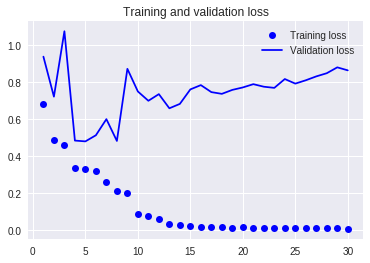

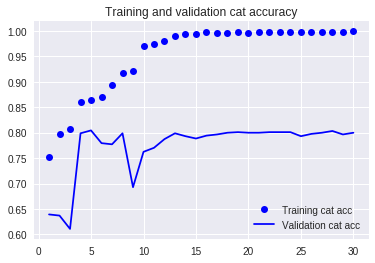

In [0]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


In [0]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [0]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [0]:
# Print the label associated with each class
test_batches.class_indices

{'bacterial': 0, 'normal': 1, 'viral': 2}

In [0]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=val_steps, verbose=1)

88/88 [==============================] - 11s 130ms/step


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
test_labels.shape

(879,)

In [0]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [0]:
test_batches.class_indices

{'bacterial': 0, 'normal': 1, 'viral': 2}

Confusion matrix, without normalization
[[343  19  55]
 [ 18 197  23]
 [ 99   6 119]]


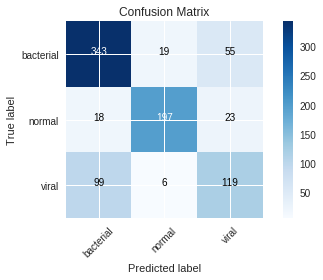

In [0]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['bacterial', 'normal', 'viral']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


In [0]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_batches.filenames

# Get the true labels
y_true = test_batches.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [0]:
from sklearn.metrics import classification_report

# Generate a classification report


report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

   bacterial       0.75      0.82      0.78       417
      normal       0.89      0.83      0.86       238
       viral       0.60      0.53      0.57       224

   micro avg       0.75      0.75      0.75       879
   macro avg       0.75      0.73      0.73       879
weighted avg       0.75      0.75      0.75       879



## End of model building and evaluation

## Converting model to be used by tensorflow.js

In [0]:
!pip install tensorflowjs

    100% |████████████████████████████████| 307kB 10.0MB/s 
    100% |████████████████████████████████| 13.9MB 3.3MB/s 
    100% |████████████████████████████████| 61kB 17.9MB/s 
    100% |████████████████████████████████| 51kB 18.3MB/s 
tensorflow 1.12.0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.4 which is incompatible.
tensorflow 1.12.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.2 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.0 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: Keras-Preprocessing 1.0.5
    Uninstalling Keras-Preprocessi

In [0]:
# create a directory to store the model files
os.mkdir('tfjs_dir')

# convert to Tensorflow.js
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'tfjs_dir')

In [0]:
# view the files that make up the tensorflow.js model
os.listdir('tfjs_dir')

['group1-shard2of4',
 'group1-shard3of4',
 'model.json',
 'group1-shard1of4',
 'group1-shard4of4']

In [0]:
shutil.rmtree('base_dir2')

In [0]:
shutil.rmtree('base_dir')